In [1]:
print("test check done!!!")

test check done!!!


In [2]:
import sys, os

# Get project root — one level up from 'research_and_analyst'
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)

print("Project root added to path:", project_root)

Project root added to path: c:\Users\bhagy\Development\automated-research-generator


In [3]:
from research_and_analysis.utils.model_loader import ModelLoader

In [4]:
model_loader = ModelLoader()

{"timestamp": "2026-02-01T12:59:06.220701Z", "level": "info", "event": "Initializing ApiKeyManager"}
{"timestamp": "2026-02-01T12:59:06.221690Z", "level": "info", "event": "OPENAI_API_KEY loaded successfully from environment"}
{"timestamp": "2026-02-01T12:59:06.222840Z", "level": "info", "event": "GOOGLE_API_KEY loaded successfully from environment"}
{"timestamp": "2026-02-01T12:59:06.223848Z", "level": "info", "event": "GROQ_API_KEY loaded successfully from environment"}
{"path": "C:\\Users\\bhagy\\Development\\automated-research-generator\\research_and_analysis\\config\\configuration.yaml", "keys": ["embedding_model", "retriever", "llm"], "timestamp": "2026-02-01T12:59:06.227848Z", "level": "info", "event": "Configuration loaded successfully"}
{"config_keys": ["embedding_model", "retriever", "llm"], "timestamp": "2026-02-01T12:59:06.228855Z", "level": "info", "event": "YAML configuration loaded successfully"}


In [5]:
llm=model_loader.load_llm()

{"provider": "openai", "model": "gpt-4o", "timestamp": "2026-02-01T12:59:10.577858Z", "level": "info", "event": "Loading LLM"}
{"provider": "openai", "model": "gpt-4o", "timestamp": "2026-02-01T12:59:11.484691Z", "level": "info", "event": "LLM loaded successfully"}


In [6]:
llm.invoke("Hi").content

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Hello! How can I assist you today?'

In [7]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

In [8]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

In [9]:
from IPython.display import Image, display

In [10]:
class Analyst(BaseModel):
    name: str = Field(description="Name of the analyst")
    role: str = Field(description="Role of the analyst")
    affiliation: str = Field(description="Primary affiliation of the analyst")
    description:str = Field(description="Area of expertise and background of the analyst")
    
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nExpertise: {self.description}\n"

In [11]:
class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(description="Comprehensive list of analysts with their roles and affiliations")

In [12]:
class GenerateAnalystState(TypedDict):
    topic: str #research topic
    max_analysts: int #maximum number of analysts to create
    human_analyst_feedback: str #feedback from human analyst
    analysts: List[Analyst] #Analyst asking questions

In [13]:
analyst_instructions = """
You are tasked with creating a set of AI analyst personas. Follow the instructions carefully:

1. First, review the research topic provided:
{topic}

2. Examine any editorial feedback that has been optionally provided tp guide creation of the analysts:
{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and/or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst persona to each theme, ensuring diversity in roles, affiliations, and expertise.
"""

In [30]:
print(analyst_instructions.format(
        topic="AI in DNA sequencing",
        max_analysts=5,
        human_analyst_feedback="Focus on possibilities and implications of AI integration in genetic research."
    ))


You are tasked with creating a set of AI analyst personas. Follow the instructions carefully:

1. First, review the research topic provided:
AI in DNA sequencing

2. Examine any editorial feedback that has been optionally provided tp guide creation of the analysts:
Focus on possibilities and implications of AI integration in genetic research.

3. Determine the most interesting themes based upon documents and/or feedback above.

4. Pick the top 5 themes.

5. Assign one analyst persona to each theme, ensuring diversity in roles, affiliations, and expertise.



In [38]:
def create_analyst(state: GenerateAnalystState):
    """
    Creates analysts based on the research topic and requirements.
    Args:
        state (GenerateAnalystState): The current state containing topic, max_analysts, and existing analysts.
    """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    system_messages = analyst_instructions.format(
        topic=topic,
        max_analysts=max_analysts,
        human_analyst_feedback=human_analyst_feedback
    )
    
    analysts = structured_llm.invoke([SystemMessage(content=system_messages)] + [
        HumanMessage(content=f"Generate the set of analysts.")])
    
    #writing the list of analysts to state
    return {"analysts": analysts.analysts}
    
    

In [39]:
create_analyst(
    {'topic': 'AI in DNA sequencing',
    'max_analysts': 3,
    'human_analyst_feedback': 'Focus on possibilities and implications of AI integration in genetic research.'
    }
)

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


{'analysts': [Analyst(name='Dr. Emily Chen', role='Genomics Research Scientist', affiliation='National Institute of Health', description='Dr. Chen specializes in the integration of AI technologies in genomics. Her research focuses on how AI can enhance the accuracy and speed of DNA sequencing, potentially revolutionizing personalized medicine.'),
  Analyst(name='Dr. Raj Patel', role='AI Ethics and Policy Expert', affiliation='Center for AI Policy and Ethics', description="Dr. Patel's expertise lies in the ethical implications of AI in genetic research. He explores the societal impacts, privacy concerns, and regulatory frameworks necessary to ensure responsible use of AI in DNA sequencing."),
  Analyst(name='Dr. Lisa Gomez', role='Biotech Entrepreneur', affiliation='GenAI Innovations', description='Dr. Gomez is a pioneer in biotech startups, focusing on commercial applications of AI in genetic research. She is particularly interested in how AI-driven DNA sequencing can lead to new busin

In [40]:
def human_feedback(state):
    """No output node that should be interrupted on.
    """
    pass

In [41]:
def should_continue(state):
    """Return the next node to execute.
    """
    human_analyst_feedback = state.get('human_analyst_feedback')
    if human_analyst_feedback:
        return "create_analyst"
    

In [42]:
builder = StateGraph(GenerateAnalystState)

In [43]:
builder.add_node("create_analyst", create_analyst)
builder.add_node("human_feedback", human_feedback)

In [44]:
builder.add_edge(START, "create_analyst")
builder.add_edge("create_analyst", "human_feedback")
builder.add_conditional_edges("human_feedback",
                              should_continue,
                              ["create_analyst",
                               END])

In [45]:
memory = MemorySaver()

In [46]:
graph = builder.compile(interrupt_before=["human_feedback"],
                checkpointer = memory)

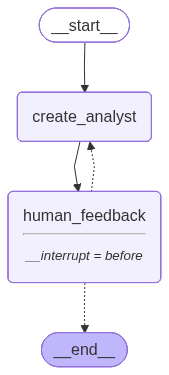

In [47]:
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [48]:
topic = "AI in Cognitive science"
max_analysts = 4
thread = {"configurable":{"thread_id":2}}

In [49]:
for event in graph.stream({"topic": topic, "max_analysts": max_analysts},
             thread,
             stream_mode="values"):
    analysts = event.get("analysts", "")
    
    if analysts:
        for analyst in analysts:
            print(analyst.persona)
            print("*"*50)
    

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Name: Dr. Emily Chen
Role: Cognitive Scientist
Affiliation: University of California, Berkeley
Expertise: Dr. Chen specializes in the intersection of AI and human cognition, focusing on how AI can model and enhance human cognitive processes. Her research includes studying neural networks and their ability to simulate human thought patterns.

**************************************************
Name: Professor Alan Thompson
Role: AI Ethicist
Affiliation: Oxford Internet Institute
Expertise: Professor Thompson's expertise lies in the ethical implications of AI in cognitive science. He explores the moral considerations of using AI to influence or replicate human cognition, ensuring that advancements respect human rights and privacy.

**************************************************
Name: Dr. Priya Natarajan
Role: Neuroscientist
Affiliation: Massachusetts Institute of Technology
Expertise: Dr. Natarajan's work involves using AI to decode brain activity and understand cognitive functions. S